## MIBI Pixel Transform
Train a pixel transform model and run it on provided data

In [1]:
import os
import errno
import random
import shutil
import zipfile
import importlib

import numpy as np
from tensorflow.python import keras

from deepcell.utils.data_utils import get_data
from deepcell.utils.io_utils import get_image_sizes
from deepcell.utils.export_utils import export_model
from deepcell.utils.train_utils import rate_scheduler
from deepcell.model_zoo import bn_feature_net_2D
from deepcell.model_zoo import bn_feature_net_skip_2D
import matplotlib.pyplot as plt
import xarray as xr

/usr/local/lib/python3.5/dist-packages/deepcell/utils/__init__.py:49: UserWarning: To use `compute_overlap`, the C extensions must be built using `python setup.py build_ext --inplace`
  warnings.warn('To use `compute_overlap`, the C extensions must be built '


In [2]:
# filepath constants
NPZ_DIR = "/data/npz_data"
LOG_DIR = "/data/logs"

# Check for channels_first or channels_last
IS_CHANNELS_FIRST = keras.backend.image_data_format() == "channels_first"
ROW_AXIS = 2 if IS_CHANNELS_FIRST else 1
COL_AXIS = 3 if IS_CHANNELS_FIRST else 2
CHANNEL_AXIS = 1 if IS_CHANNELS_FIRST else 3

In [3]:
# create folder for this set of experiments
experiment_folder = "20190822_training_freeze_1"
MODEL_DIR = os.path.join("/data/models", experiment_folder)
if not os.path.isdir(MODEL_DIR):
    os.makedirs(MODEL_DIR)

In [4]:
npz_name = "Training_Freeze_1"
MODEL_NAME = npz_name + '_81_rf_512_dense_128_conv'
n_epoch = 30

In [5]:
# Load the training data from NPZ into a numpy array
training_data = np.load(os.path.join(NPZ_DIR, npz_name + ".npz"))
RESIZE = False

X, y = training_data["X"], training_data["y"]
print("X.shape: {} & y.shape: {}".format(X.shape, y.shape))

# save the size of the input data for input_shape model parameter
size = (RESHAPE_SIZE, RESHAPE_SIZE) if RESIZE else X.shape[ROW_AXIS:COL_AXIS + 1]
if IS_CHANNELS_FIRST:
    input_shape = (X.shape[CHANNEL_AXIS], size[0], size[1])
else:
    input_shape = (size[0], size[1], X.shape[CHANNEL_AXIS])

# Set up other training parameters
batch_size = 32
optimizer = keras.optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
lr_sched = rate_scheduler(lr=0.01, decay=0.99)

X.shape: (4, 1024, 1024, 5) & y.shape: (4, 1024, 1024, 1)


In [6]:
# Instantiate the model
model = bn_feature_net_2D(
    n_features=3,
    n_dense_filters=512,
    n_channels=X.shape[CHANNEL_AXIS],
    receptive_field=81,
    reg=1e-05,
    norm_method="std",
    input_shape=input_shape,
    n_conv_filters=128,
)

In [7]:
print(MODEL_NAME)

Training_Freeze_1_81_rf_512_dense_128_conv


In [ ]:
# Train the model
model = deepcell.training.train_model_sample(
    max_class_samples=400000,
    dataset=os.path.join(NPZ_DIR, npz_name + ".npz"),
    direc_data=NPZ_DIR,
    batch_size=batch_size,
    rotation_range=180,
    balance_classes=True,
    model=model,
    n_epoch=n_epoch,
    model_dir=MODEL_DIR,
    transform="deepcell",
    log_dir=LOG_DIR,
    dilation_radius=1,
    shear=False,
    lr_sched=lr_sched,
    window_size=(40, 40),
    flip=True,
    optimizer=optimizer,
    expt="sample_deepcell",
    model_name=MODEL_NAME,
    val_monitor=False,
    separate_edge_classes=False,
    save_period=3,
    class_weights=None
    #class_weights={0:3, 1:1, 2:1}
)

using all data as training data
Using class weights of {0: 1.0, 1: 1.0, 2: 1.0}
X_train shape: (4, 1024, 1024, 3)
y_train shape: (4, 1024, 1024, 1)
Output Shape: (None, 3)
Number of Classes: 3
Training on 1 GPUs
the max_class_samples per image is 100000
analyzing image 0
the least represented class has 77587 examples
analyzing class 0
downsampling from 93059 examples per class
analyzing class 1
downsampling from 718603 examples per class
analyzing class 2
downsampling from 77587 examples per class
analyzing image 1
the least represented class has 71519 examples
analyzing class 0
downsampling from 71519 examples per class
analyzing class 1
downsampling from 537984 examples per class
analyzing class 2
downsampling from 279746 examples per class
analyzing image 2
the least represented class has 83101 examples
analyzing class 0
downsampling from 83101 examples per class
analyzing class 1
downsampling from 563047 examples per class
analyzing class 2
downsampling from 243101 examples per cla

In [8]:
# assess accuracy of trained model
hist = np.load(os.path.join(MODEL_DIR, MODEL_NAME + '.npz'))
hist['loss_history'].tolist()['acc']

[0.6988382799978848,
 0.7308707223858001,
 0.7473643713966159,
 0.7583496260045147,
 0.7658863002811347,
 0.7720417765102021,
 0.777330692870238,
 0.782300483104576,
 0.7860555758781983,
 0.7894322582278748,
 0.7928707476122594,
 0.7951588693098036,
 0.7984674377825683,
 0.8009510715320335,
 0.8032227954437882,
 0.8048285170103003,
 0.8070775362955658,
 0.8095359426832841,
 0.8106572989066946,
 0.8124169073772908,
 0.8142585047748796,
 0.8155577138963418,
 0.8171445149415064,
 0.8181346888838639,
 0.8200771957270864,
 0.8212086428939326,
 0.8226705684981425,
 0.8231662861538123,
 0.82508230426796,
 0.8253951235517553,
 0.8270651748892858,
 0.8282584290927949,
 0.8288689312434274,
 0.8294012285728105,
 0.8306171874022075,
 0.8314421221264093,
 0.8322203862316578,
 0.8332988559394523,
 0.8337491643439479,
 0.8354684090358394,
 0.8355491365938501,
 0.8366049016762078]

In [9]:
# load specific epoch of trained model to identify best version of the model
EPOCH_NAME = "_epoch_18"
weights_path = os.path.join(MODEL_DIR, MODEL_NAME + EPOCH_NAME + ".h5")

In [10]:
run_sample_model = bn_feature_net_2D(
    n_dense_filters=512,
    n_conv_filters=128,
    dilated=True,
    n_features=3,
    norm_method='std',
    receptive_field=81,
    n_channels=3,    
    input_shape=tuple(X.shape[1:]))

run_sample_model.load_weights(weights_path)

In [24]:
# load validation data
test_xr = pass

In [11]:
#test_xr = xr.open_dataarray('/data/npz_data/TA489_Blanked.nc')
test_images = run_sample_model.predict(X[:1, :, :, :])
print('model output shape:', test_images.shape)

model output shape: (1, 1024, 1024, 3)


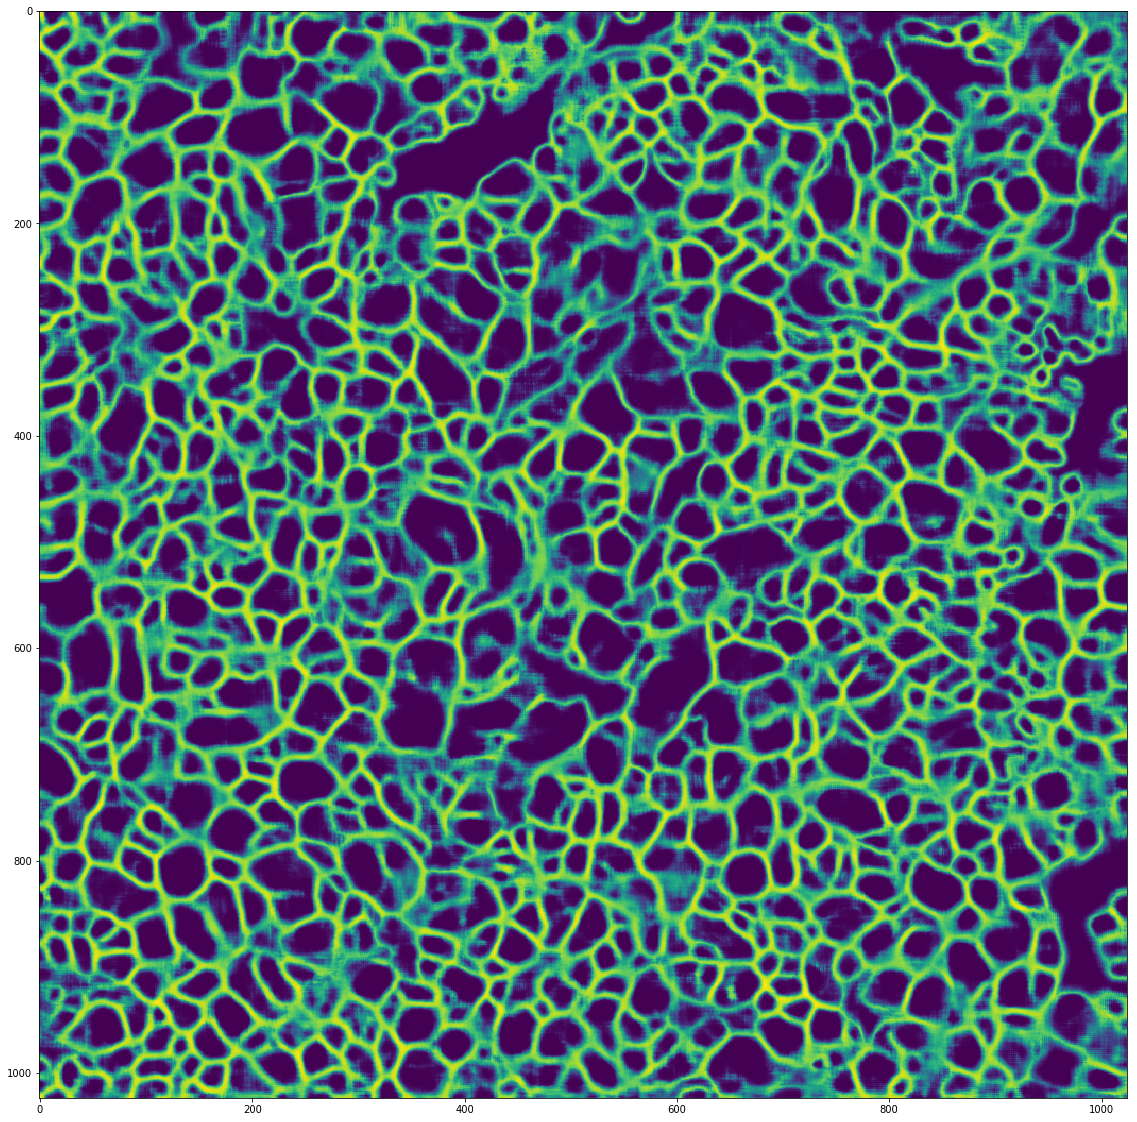

In [12]:
plt.figure(figsize = (20, 20))
plt.imshow(test_images[0, :, :, 0])

In [13]:
xr_output = xr.DataArray(test_images, name=MODEL_NAME,
                         coords=[['point1'], range(1024), range(1024), ['border', 'interior', 'bg']],
                         dims=['points', 'rows', 'cols', 'masks'])
xr_output.to_netcdf(os.path.join('/data/models', "20190914_tuning", MODEL_NAME + "xarray_testpoint1_output.nc"), format="NETCDF3_64BIT")

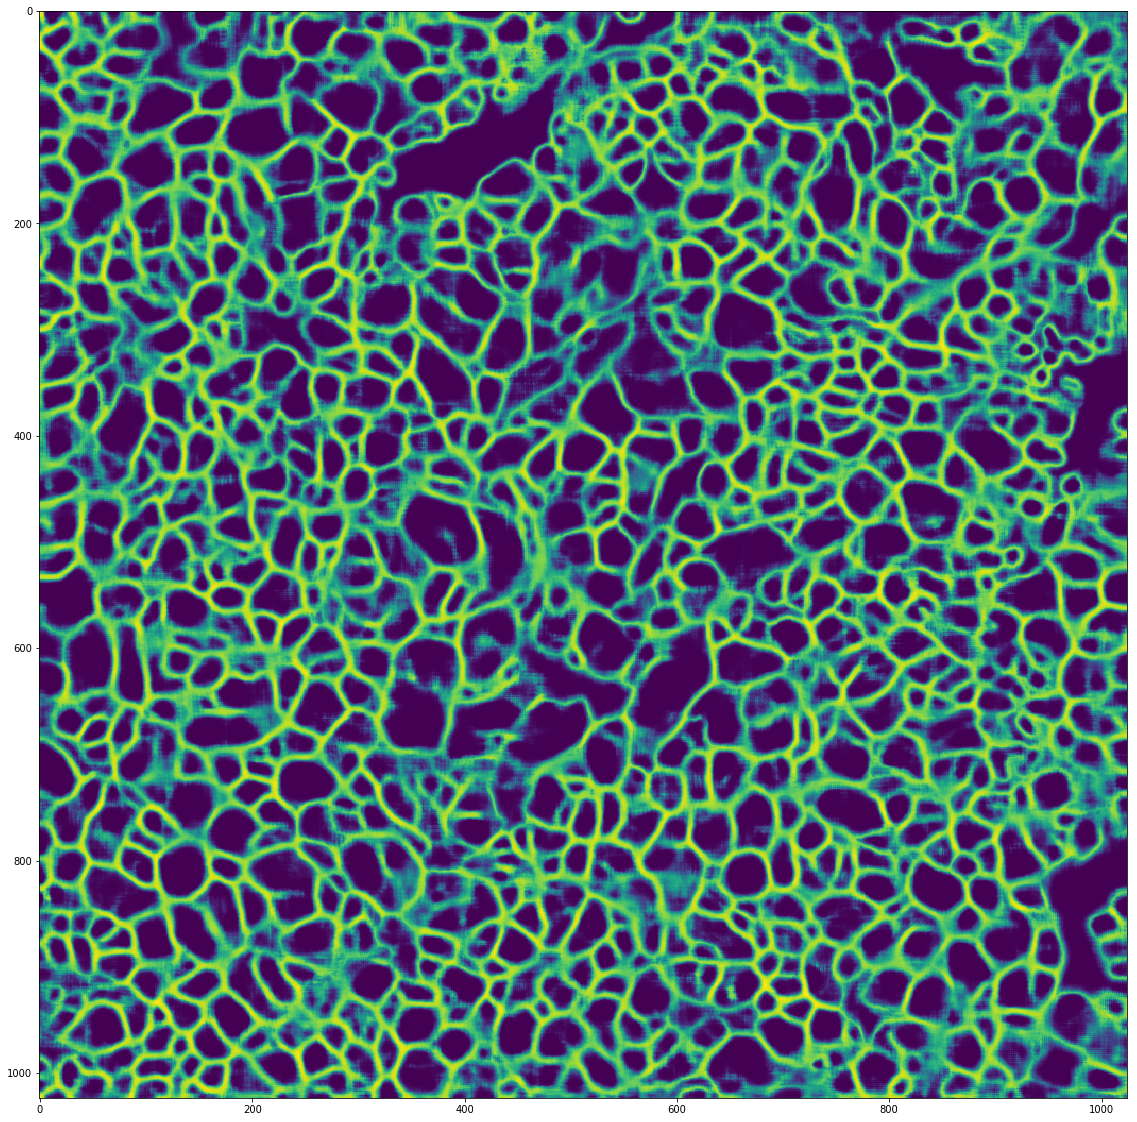

In [18]:
plt.figure(figsize = (20, 20))
plt.imshow(test_images[0, :, :, 0])